# Principal Component Analysis 
Uses Amazon SageMaker PCA to calculate eigendigits from MNIST.

### Import packages 
* io -  module provides the Python interfaces to stream handling.
* os -  provides a portable way of using operating system dependent functionality.

In [5]:
import io
import os

### Importing some standard python packages 
* gzip   - module provides a simple interface to compress and decompress files
* pickle - module implements an algorithm for serializing and de-serializing a Python object structure.
* numpy  - package for scientific computing with Python.
* urllib.request    - module defines functions and classes for opening URLs.
* matplotlib.pyplot - Provides a MATLAB-like plotting framework.

In [6]:
import gzip  
import pickle
import numpy as np
import urllib.request

import matplotlib.pyplot as plt
%matplotlib inline

### Importing amazon packages
* boto3 - The AWS SDK for Python to write software that uses Amazon services like S3 and EC2.
* sagemaker - Python SDK for training and deploying machine learning models on Amazon SageMaker.
* sagemaker.amazon.common - includes high-level Python library functions to convert the training data
* get_execution_role - Return the role ARN whose credentials are used to call the API.
* csv_serializer - Defines behavior for serialization of input data.
* json_deserializer - Defines behavior for deserialization of result data.

In [7]:
import boto3
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker.predictor import csv_serializer, json_deserializer
from sagemaker import get_execution_role

## Get the MNIST dataset. 
* Check if the dataset exists on the machine on which the instance runs
* If not, download it from the url specified.

In [8]:
DOWNLOADED_FILENAME = 'mnist.pkl.gz'

In [9]:
if not os.path.exists(DOWNLOADED_FILENAME):
    urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", DOWNLOADED_FILENAME)

## Preprocessing and splitting the dataset 

* The pickled file represents a tuple of 3 lists : **(training set, validation set, test set)**
* Each of the three lists is a tuple: **(list of images, list of class labels)**
* Image: Numpy 1-dimensional array of 784 (28 x 28) float values between 0 and 1
* Labels: Numbers between 0 and 9 indicating which digit the image represents

In [10]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

### Inspecting the data
* Inspect the length and shape of the three tuples and numpy arrays
* The tuples contain images and respective labels
* Plot an image and inspect its label 

In [11]:
print(len(train_set))

2


In [12]:
print(len(train_set[0]))

50000


In [13]:
print(train_set[0].shape)

(50000, 784)


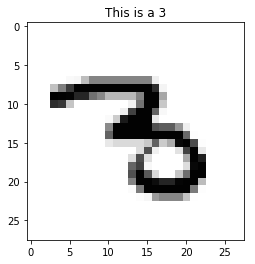

In [14]:
def show_digit(img, caption =''):
    plt.imshow(img.reshape(28,28), cmap="Greys",  interpolation='nearest')
    plt.title(caption)
    
show_digit(train_set[0][30],'This is a {}'.format(train_set[1][30]))

### Preprocessing the data
* Amazon SageMaker implementation of PCA only takes recordIO-wrapped protobuf
* Define array to store image vectors
* Create IOBuffer to write the data in memory buffer and store on the tensor.
* Invoke method to convert the training data into the protobuf format, only training data and not labels
* Move to the start of the buffer.

In [15]:
vectors = train_set[0].T

print(train_set[0].shape)
print(vectors.shape)

(50000, 784)
(784, 50000)


In [16]:
buf = io.BytesIO()

In [17]:
smac.write_numpy_to_dense_tensor(buf, vectors)

In [18]:
buf.seek(0)

0

## Move the training data to S3 bucket

* Construct bucket path by specifying bucket name and prefix
* Define a key, the object reference to the unique identifier within a bucket
* Create bucket resource and upload buffer
* Set up path where output of our model is stored

In [19]:
key = 'recordio-pb-data'

In [20]:
bucket_name = 'loonybucket'
prefix = 'sagemaker/pca'

In [21]:
path = os.path.join(prefix, 'train', key)

In [22]:
s3_resource = boto3.resource('s3')

In [23]:
bucket = s3_resource.Bucket(bucket_name)

In [24]:
current_bucket = bucket.Object(path)

In [25]:
train_data = 's3://{}/{}/train/{}'.format(bucket_name, prefix, key)
print('uploading training data location: {}'.format(train_data))

uploading training data location: s3://loonybucket/sagemaker/pca/train/recordio-pb-data


In [26]:
current_bucket.upload_fileobj(buf)

In [27]:
output_location = 's3://{}/{}/output'.format(bucket_name, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

training artifacts will be uploaded to: s3://loonybucket/sagemaker/pca/output


## Specifying the Algorithm

* Get the region of the current notebook instance
* Specify the algorithm container to be used. 
* Instantiate a session to access sagemaker.
* Get the role ARN whose credentials are used to call the API to instantiate the estimator
* Initialize an Estimator instance and specify the container, role, instance coutn and type, output location and session

In [28]:
region = boto3.Session().region_name
region

'us-east-2'

In [29]:
containers = {'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/pca:latest',
              'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/pca:latest',
              'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/pca:latest',
              'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/pca:latest'}
container = containers[region]

In [30]:
role = get_execution_role()
role

'arn:aws:iam::324118574079:role/service-role/AmazonSageMaker-ExecutionRole-20180209T192191'

In [31]:
sess = sagemaker.Session()

In [32]:
pca = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.c4.xlarge',
                                    output_path=output_location,
                                    sagemaker_session=sess)

## Tuning hyperparameters for optimzing performance. 
- Feature dimension is set to 50000 (number of images)
- Set num_components to 10 and may be increased to tune the performance
- subtract_mean standardizes the pixel intensity across all images
- Set Algorithm mode to "randomized" as we have large feature dim and "regular" is a good choice for lower dimension of features. The Amazon SageMaker PCA algorithm uses either of two modes to calculate these summaries, depending on the situation; **regular** is for datasets with sparse data and a moderate number of observations and features and **randomized** for datasets with both a large number of observations and features. This mode uses an approximation algorithm.
- Set batch size to 200

In [33]:
pca.set_hyperparameters(feature_dim=50000,
                        num_components=10,
                        subtract_mean=True,
                        algorithm_mode='randomized',
                        mini_batch_size=200)

## Training and hosting the Model 
* Train a model using the input training dataset.The fit API calls the Amazon SageMaker CreateTrainingJob API to start model training. The API uses configuration you provided to create the estimator and the specified input training data to send the CreatingTrainingJob request to Amazon SageMaker.This is a synchronous operation. 

* After the model training successfully completes, call the deploy() method to host the model using the Amazon SageMaker hosting services.
* Initialize a predictor object to make prediction requests to an Amazon SageMaker endpoint.

In [35]:
pca.fit({'train': train_data})

INFO:sagemaker:Creating training-job with name: pca-2018-03-08-16-30-14-695


.......................................................................
Docker entrypoint called with argument(s): train
[03/08/2018 16:36:01 INFO 140415894349632] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[03/08/2018 16:36:01 INFO 140415894349632] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'algorithm_mode': u'randomized', u'feature_dim': u'50000', u'mini_batch_size': u'200', u'num_components': u'10', u'subtract_mean': u'True'}
[03/08/2018 16:36:01 INFO 140415894349632] Final configuration: {u'num_components': u'10', u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'True', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'rand

===== Job Complete =====


In [36]:
pca_predictor = pca.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: pca-2018-03-08-16-41-50-777
INFO:sagemaker:Creating endpoint with name pca-2018-03-08-16-30-14-695


-------------------------------------------------------------------------------------------------------------!

## Validate the model for use. 
* Set the invocation’s 'ContentType', overriding any content_type from the serializer
* Specify how to serialize requests and deserialize responses that are specific to the algorithm.
* Serializer accepts a single argument, the input data, and returns a sequence of bytes. 
* Content type options for Amazon SageMaker algorithm inference requests include: text/csv, application/json, and application/x-recordio-protobuf. 
* Deserializer accepts two arguments, the result data and the response content type, and returns a sequence of bytes.
* Amazon SageMaker algorithms return JSON.

In [37]:
pca_predictor.content_type = 'text/csv'
pca_predictor.serializer = csv_serializer
pca_predictor.deserializer = json_deserializer

### Try getting the eigen digit for a single record.

In [38]:
train_set[0].shape

(50000, 784)

In [39]:
train_set[0][:, 0].shape

(50000,)

In [40]:
train_set[0][:, 0]

array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32)

In [41]:
result = pca_predictor.predict(train_set[0][:, 0])
result

{'projections': [{'projection': [-28.305532455444336,
    2.799952507019043,
    6.037816524505615,
    0.908909797668457,
    -0.03693847358226776,
    -0.43731558322906494,
    -2.042056083679199,
    1.9561119079589844,
    -0.4224138855934143,
    3.8184704780578613]}]}

We see that for one record our endpoint returned some JSON which contains a value for each of the 10 principal components we created when training the model.

### Running the model on the whole test set. 
* Split the train set array into multiple sub-arrays of length 50 each
* Hit the endpoint with each sub-array using the predictor object
* Results array will contain the eigen digits
* Store all resultant images into a numpy array, eigendigits
* View all the eigen digits

In [42]:
eigendigits = []
for array in np.array_split(train_set[0].T, 50):
    result = pca_predictor.predict(array)
    eigendigits += [r['projection'] for r in result['projections']]

In [43]:
result

{'projections': [{'projection': [-28.101720809936523,
    2.229731559753418,
    6.0010223388671875,
    1.190658688545227,
    -0.10508857667446136,
    0.2010747790336609,
    -1.933085560798645,
    1.9597439765930176,
    -0.4709984064102173,
    3.3910770416259766]},
  {'projection': [-28.09722328186035,
    2.0829410552978516,
    5.8935370445251465,
    1.1971213817596436,
    -0.01040557399392128,
    0.17018526792526245,
    -1.9517412185668945,
    1.9509828090667725,
    -0.5437526106834412,
    3.44905948638916]},
  {'projection': [-28.144262313842773,
    2.151416540145874,
    5.807415008544922,
    1.021557092666626,
    0.03277701139450073,
    0.005048990249633789,
    -2.094083547592163,
    1.9792406558990479,
    -0.5088934898376465,
    3.593938112258911]},
  {'projection': [-28.1879825592041,
    2.2786927223205566,
    5.750580787658691,
    0.8051127195358276,
    0.0037680789828300476,
    -0.175897479057312,
    -2.1613380908966064,
    2.062469005584717,
    

In [44]:
eigendigits = np.array(eigendigits).T

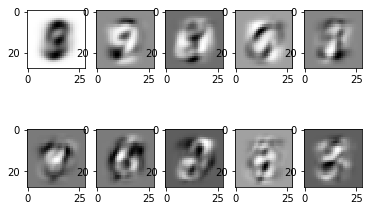

In [47]:
for i in range(10):
    plt.subplot(2, 5, i + 1)
    show_digit(eigendigits[i])

The eigendigits aren't extremely interpretable. They do show interesting elements of the data, with eigendigit #0 being the "anti-number", eigendigit #1 looking a bit like a 0 combined with the inverse of a 3, eigendigit #2 showing some shapes resembling a 9, and so on.

### Delete the endpoint when you are done.

In [89]:
sess.delete_endpoint(pca_predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: pca-2018-03-06-11-27-09-211
